<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_End_To_End_MN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End memory Network



Dans ce carnet nous allons mettre en place un modèle à réseau de neurones à mémoire de type **End-To-End Memory Network**.  
Le papier de recherche associé est disponible [ici](https://arxiv.org/pdf/1503.08895)

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/EndToEnd.png?raw=true" width="1200"> 

In [11]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

Pour l'entrainement, nous devons préparer le dataset de la manière suivante :

In [12]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange,nbr_sequences):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.window(nbr_sequences+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(nbr_sequences+1,drop_remainder=True))
  dataset = dataset.map(lambda x: [(tf.slice(x,[0,0],[nbr_sequences,taille_fenetre]),                           # (30;20)       [((30,20),(20)),(1)]
                                   tf.squeeze(tf.slice(x,[nbr_sequences,0],[1,taille_fenetre]),axis=0)),        # (20)
                                   tf.squeeze(tf.slice(x,[nbr_sequences,taille_fenetre],[1,1]),axis=0)])        # (1)
  dataset = dataset.batch(batch_size,drop_remainder=True)
  return dataset

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000
Nbr_Sequences = 30

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)

In [13]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)

# Normalise les données
Serie_Normalisee = (serie-mean)/std
min = tf.math.reduce_min(serie)
max = tf.math.reduce_max(serie)

# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)

Essai de préparation des données :

In [4]:
x = tf.linspace(1,1000,1000)
data_test = prepare_dataset_XY(x,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)

In [5]:
print(len(list(data_test.as_numpy_iterator())))
for element in data_test.take(1):
  print(element)

29
((<tf.Tensor: shape=(32, 30, 20), dtype=float64, numpy=
array([[[ 1.,  2.,  3., ..., 18., 19., 20.],
        [ 2.,  3.,  4., ..., 19., 20., 21.],
        [ 3.,  4.,  5., ..., 20., 21., 22.],
        ...,
        [28., 29., 30., ..., 45., 46., 47.],
        [29., 30., 31., ..., 46., 47., 48.],
        [30., 31., 32., ..., 47., 48., 49.]],

       [[ 2.,  3.,  4., ..., 19., 20., 21.],
        [ 3.,  4.,  5., ..., 20., 21., 22.],
        [ 4.,  5.,  6., ..., 21., 22., 23.],
        ...,
        [29., 30., 31., ..., 46., 47., 48.],
        [30., 31., 32., ..., 47., 48., 49.],
        [31., 32., 33., ..., 48., 49., 50.]],

       [[ 3.,  4.,  5., ..., 20., 21., 22.],
        [ 4.,  5.,  6., ..., 21., 22., 23.],
        [ 5.,  6.,  7., ..., 22., 23., 24.],
        ...,
        [30., 31., 32., ..., 47., 48., 49.],
        [31., 32., 33., ..., 48., 49., 50.],
        [32., 33., 34., ..., 49., 50., 51.]],

       ...,

       [[30., 31., 32., ..., 47., 48., 49.],
        [31., 32., 33., ...,

# Création du modèle End-To-End Memory Network (à base de couches GRU)

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/EndToEnd2.png?raw=true"> 

In [6]:
# Définition du de la couche du modèle
# End-to-End Memory Network
# Epaquetage des données avec le dernier état caché d'une couche GRU

from keras import backend as K

class Couche_End_to_End_MN(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  # dim_GRU : Dimension des vecteurs GRU
  # x : Séquences à mémoriser (batch_size, Nbr_Sequence, taille_fenetre)
  # Fonction de la couche lambda d'entrée
  def __init__(self,dim_GRU,regul=0.0):
    self.dim_GRU = dim_GRU
    self.regul = regul
    super().__init__()          # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    # Définition des couches GRU pour traiter les séquences d'entrée
    self.couche_GRU_A = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_GRU_B = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_GRU_C = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))

    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :     x : (batch_size, Nbr_Sequence, taille_fenetre)
  #                 y : (batch_size, taille_fenetre)
  # Exemple :   batch_size = 32
  #             Nbr_Sequence =30
  #             taille_fenetre = 20
  #             dim_GRU = 40 
  def call(self,x,y):
    # Création des vecteurs mi dans le tenseur M
    M = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    M = tf.keras.layers.TimeDistributed(self.couche_GRU_A)(M)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    M = K.tanh(M)

    # Création du vecteur d'état u
    u = tf.expand_dims(y,axis=-1)                                   # (32,20) => (32,20,1)
    u = self.couche_GRU_B(u)                                        # (32,20,1) => (32,40)
    u = tf.expand_dims(u,axis=-1)                                   # (32,40) => (32,40,1)
    u = K.tanh(u)                                                   # (32,40,1)

    # Calcul des poids d'attention
    p = tf.matmul(M,u)                                              # (32,30,40)x(32,40,1)=(32,30,1)
    p = tf.keras.activations.softmax(p,axis=1)                      # (32,30,1)

    # Création des vecteurs ci dans le tenseur C
    C = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    C = tf.keras.layers.TimeDistributed(self.couche_GRU_C)(C)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    C = K.tanh(C)

    # Calcul du vecteur réponse issu de la mémoire
    o = tf.multiply(C,p)                                            # (32,30,40)_x_(32,30,1) = (32,30,40)
    o = K.sum(o, axis=1)                                            # (32,40)
    o = K.tanh(o)                                                   # (32,40)
    
    # Retourne le vecteur d'attention
    return (o+tf.squeeze(u,axis=2))


In [7]:
dim_GRU = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition des entrées du modèle
entrees_sequences = tf.keras.layers.Input(shape=(Nbr_Sequences,taille_fenetre),batch_size=batch_size)
entrees_entrainement = tf.keras.layers.Input(shape=(taille_fenetre),batch_size=batch_size)

# Encodeur
s_encodeur = Couche_End_to_End_MN(dim_GRU=dim_GRU,regul=1e-5)(entrees_sequences,entrees_entrainement)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_GRU,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model([entrees_sequences,entrees_entrainement],sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 30, 20)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 20)]           0                                            
__________________________________________________________________________________________________
couche__end_to__end_mn (Couche_ (32, 40)             15480       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (32, 40)             1640        couche__end_to__end_mn[0][0] 

**2. Optimisation du taux d'apprentissage**

In [8]:
# Charge les poids initiaux
model.load_weights("model_initial.hdf5")

In [15]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_opti.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
29/29 [==============================] - 8s 110ms/step - loss: 0.6710 - mae: 1.1051

Epoch 00001: loss improved from inf to 0.37853, saving model to poids_opti.hdf5
Epoch 2/100
29/29 [==============================] - 3s 116ms/step - loss: 0.6710 - mae: 1.1051

Epoch 00002: loss improved from 0.37853 to 0.37852, saving model to poids_opti.hdf5
Epoch 3/100
29/29 [==============================] - 3s 111ms/step - loss: 0.6710 - mae: 1.1051

Epoch 00003: loss improved from 0.37852 to 0.37852, saving model to poids_opti.hdf5
Epoch 4/100
29/29 [==============================] - 3s 109ms/step - loss: 0.6710 - mae: 1.1051

Epoch 00004: loss improved from 0.37852 to 0.37852, saving model to poids_opti.hdf5
Epoch 5/100
29/29 [==============================] - 3s 109ms/step - loss: 0.6710 - mae: 1.1051

Epoch 00005: loss improved from 0.37852 to 0.37852, saving model to poids_opti.hdf5
Epoch 6/100
29/29 [==============================] - 3s 109ms/step - loss: 0.6710 - mae: 1.1051

Ep

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

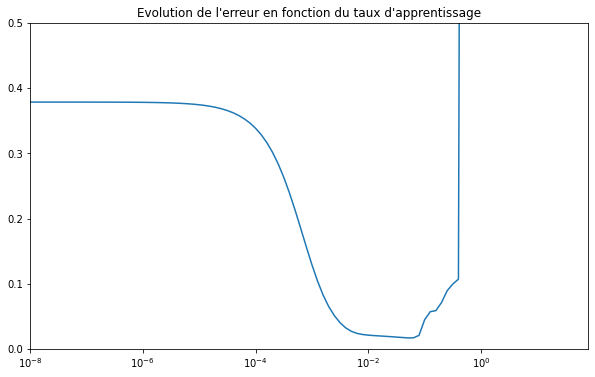

In [16]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 0.5])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [21]:
# Charge les meilleurs poids
model.load_weights("poids_opti.hdf5")

In [9]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.n_steps = 0
        self.t_step = 0
        self.n_batch = 0
        self.total_batch = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.t_step = self.t_step  + timer()-self.starttime
        self.n_steps = self.n_steps + 1
        if (self.total_batch == 0):
          self.total_batch=self.n_batch - 1
    def on_train_batch_begin(self,batch,logs=None):
      self.n_batch= self.n_batch + 1
    def GetInfos(self):
      return([self.t_step/(self.n_steps*self.total_batch), self.t_step, self.total_batch])

cb = TimingCallback()

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.02,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=100,verbose=1, callbacks=[CheckPoint,cb])

# Affiche quelques informations sur les timings
infos = cb.GetInfos()
print("Step time : %.3f" %infos[0])
print("Total time : %.3f" %infos[1])

Epoch 1/100
29/29 [==============================] - 10s 182ms/step - loss: 0.3635 - mae: 0.7495 - val_loss: 0.0798 - val_mae: 0.3472

Epoch 00001: loss improved from inf to 0.22231, saving model to poids_train.hdf5
Epoch 2/100
29/29 [==============================] - 4s 134ms/step - loss: 0.1990 - mae: 0.5313 - val_loss: 0.0149 - val_mae: 0.1254

Epoch 00002: loss improved from 0.22231 to 0.10658, saving model to poids_train.hdf5
Epoch 3/100
29/29 [==============================] - 4s 134ms/step - loss: 0.0336 - mae: 0.2109 - val_loss: 0.0140 - val_mae: 0.1251

Epoch 00003: loss improved from 0.10658 to 0.02398, saving model to poids_train.hdf5
Epoch 4/100
29/29 [==============================] - 4s 136ms/step - loss: 0.0171 - mae: 0.1453 - val_loss: 0.0173 - val_mae: 0.1425

Epoch 00004: loss improved from 0.02398 to 0.01594, saving model to poids_train.hdf5
Epoch 5/100
29/29 [==============================] - 4s 134ms/step - loss: 0.0169 - mae: 0.1446 - val_loss: 0.0212 - val_mae: 0

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

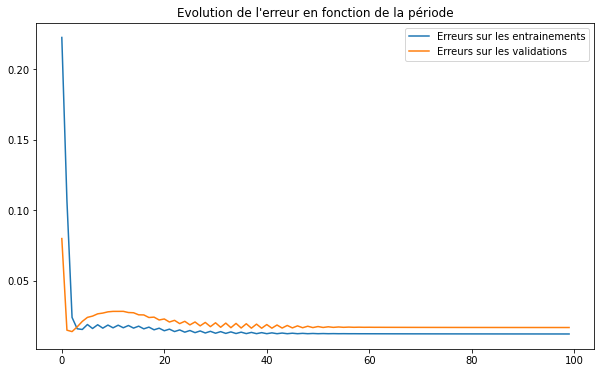

In [10]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

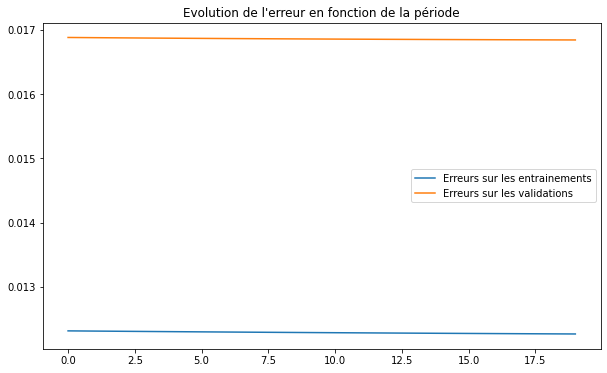

In [12]:
taille = len(erreur_entrainement)

erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[80:100])),erreur_entrainement[80:100], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[80:100])),erreur_validation[80:100], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [13]:
x_predictions = np.concatenate((x_entrainement_norm[-taille_fenetre-Nbr_Sequences:],x_validation_norm))
dataPredict = prepare_dataset_XY(x_predictions,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)
predictions = model.predict(dataPredict)

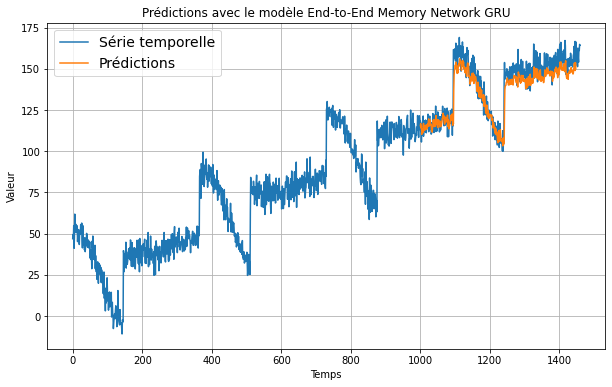

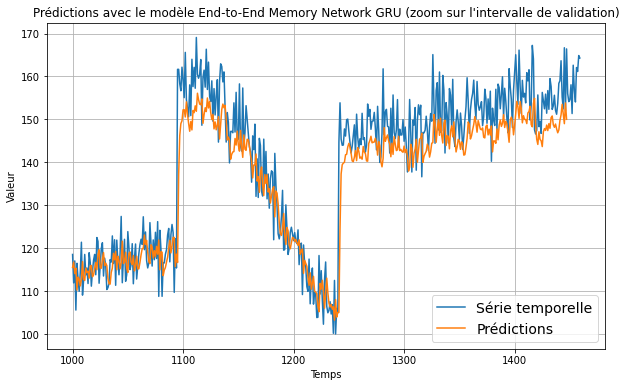

In [14]:
lag = Nbr_Sequences

# Ecart entre la taille des prédictions et la taille de la zone de validation
ecart = len(x_validation)+taille_fenetre+Nbr_Sequences - len(predictions)

# Ce qui n'a pas été pris par la prédiction
reste = ecart - taille_fenetre

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")

if reste != 0:
  affiche_serie(temps[temps_separation:-reste+Nbr_Sequences],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")


plt.title('Prédictions avec le modèle End-to-End Memory Network GRU')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
if reste != 0:
  affiche_serie(temps[temps_separation:-reste+Nbr_Sequences],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
plt.title("Prédictions avec le modèle End-to-End Memory Network GRU (zoom sur l'intervalle de validation)")
plt.show()

In [22]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:-reste+Nbr_Sequences],np.asarray(predictions[taille_fenetre:,0]*std.numpy()+mean.numpy())).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:-reste+Nbr_Sequences],np.asarray(predictions[taille_fenetre:,0]*std.numpy()+mean.numpy())).numpy()

print(mae)
print(mse)

6.0455213
62.23887


# Création du modèle End-To-End Memory Network (à base de couches LSTM)

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/EndToEnd2.png?raw=true"> 

In [14]:
# Définition du de la couche du modèle
# End-to-End Memory Network
# Epaquetage des données avec le dernier état caché d'une couche GRU

from keras import backend as K

class Couche_End_to_End_MN(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  # dim_GRU : Dimension des vecteurs GRU
  # x : Séquences à mémoriser (batch_size, Nbr_Sequence, taille_fenetre)
  # Fonction de la couche lambda d'entrée
  def __init__(self,dim_LSTM,regul=0.0):
    self.dim_LSTM = dim_LSTM
    self.regul = regul
    super().__init__()          # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    # Définition des couches GRU pour traiter les séquences d'entrée
    self.couche_LSTM_A = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_LSTM_B = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_LSTM_C = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul))

    # Poids d'attention
    self.p = self.add_weight(shape=(input_shape[1],1),initializer="zeros",name="p")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :     x : (batch_size, Nbr_Sequence, taille_fenetre)
  #                 y : (batch_size, taille_fenetre)
  # Exemple :   batch_size = 32
  #             Nbr_Sequence =30
  #             taille_fenetre = 20
  #             dim_LSTM = 40 
  def call(self,x,y):
    # Création des vecteurs mi dans le tenseur M
    M = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    M = tf.keras.layers.TimeDistributed(self.couche_LSTM_A)(M)      # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    M = K.tanh(M)

    # Création du vecteur d'état u
    u = tf.expand_dims(y,axis=-1)                                   # (32,20) => (32,20,1)
    u = self.couche_LSTM_B(u)                                       # (32,20,1) => (32,40)
    u = tf.expand_dims(u,axis=-1)                                   # (32,40) => (32,40,1)
    u = K.tanh(u)                                                   # (32,40,1)

    # Calcul des poids d'attention
    p = tf.keras.layers.Dot(axes=(2,1))([M,u])                      # (32,30,1)
    p = tf.keras.activations.softmax(p,axis=1)                      # (32,30,1)

    # Création des vecteurs ci dans le tenseur C
    C = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    C = tf.keras.layers.TimeDistributed(self.couche_LSTM_C)(C)      # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    C = K.tanh(C)

    # Calcul du vecteur réponse issu de la mémoire
    o = tf.multiply(C,p)                                            # (32,30,40)_x_(32,30,1) = (32,30,40)
    o = K.sum(o, axis=1)                                            # (32,40)
    o = K.tanh(o)                                                   # (32,40)
    
    # Retourne le vecteur d'attention
    return (o+tf.squeeze(u,axis=2))


In [15]:
dim_LSTM = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition des entrées du modèle
entrees_sequences = tf.keras.layers.Input(shape=(Nbr_Sequences,taille_fenetre),batch_size=batch_size)
entrees_entrainement = tf.keras.layers.Input(shape=(taille_fenetre),batch_size=batch_size)

# Encodeur
s_encodeur = Couche_End_to_End_MN(dim_LSTM=dim_LSTM,regul=1e-5)(entrees_sequences,entrees_entrainement)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model([entrees_sequences,entrees_entrainement],sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(32, 30, 20)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(32, 20)]           0                                            
__________________________________________________________________________________________________
couche__end_to__end_mn_2 (Couch (32, 40)             20190       input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (32, 40)             1640        couche__end_to__end_mn_2[0]

**2. Optimisation du taux d'apprentissage**

In [16]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_opti.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
29/29 [==============================] - 8s 122ms/step - loss: 0.6888 - mae: 1.1282

Epoch 00001: loss improved from inf to 0.38776, saving model to poids_opti.hdf5
Epoch 2/100
29/29 [==============================] - 4s 122ms/step - loss: 0.6888 - mae: 1.1282

Epoch 00002: loss improved from 0.38776 to 0.38776, saving model to poids_opti.hdf5
Epoch 3/100
29/29 [==============================] - 4s 122ms/step - loss: 0.6888 - mae: 1.1282

Epoch 00003: loss improved from 0.38776 to 0.38776, saving model to poids_opti.hdf5
Epoch 4/100
29/29 [==============================] - 4s 122ms/step - loss: 0.6888 - mae: 1.1281

Epoch 00004: loss improved from 0.38776 to 0.38776, saving model to poids_opti.hdf5
Epoch 5/100
29/29 [==============================] - 3s 120ms/step - loss: 0.6888 - mae: 1.1281

Epoch 00005: loss improved from 0.38776 to 0.38776, saving model to poids_opti.hdf5
Epoch 6/100
29/29 [==============================] - 4s 122ms/step - loss: 0.6888 - mae: 1.1281

Ep

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

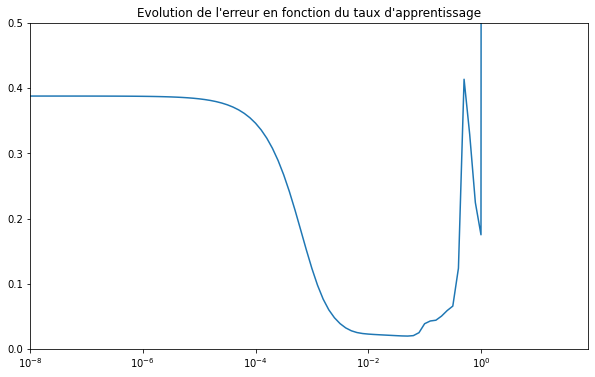

In [18]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 0.5])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [19]:
# Charge les meilleurs poids
model.load_weights("poids_opti.hdf5")

In [20]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.n_steps = 0
        self.t_step = 0
        self.n_batch = 0
        self.total_batch = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.t_step = self.t_step  + timer()-self.starttime
        self.n_steps = self.n_steps + 1
        if (self.total_batch == 0):
          self.total_batch=self.n_batch - 1
    def on_train_batch_begin(self,batch,logs=None):
      self.n_batch= self.n_batch + 1
    def GetInfos(self):
      return([self.t_step/(self.n_steps*self.total_batch), self.t_step, self.total_batch])

cb = TimingCallback()

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.07,
    decay_steps=5,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=100,verbose=1, callbacks=[CheckPoint,cb])

# Affiche quelques informations sur les timings
infos = cb.GetInfos()
print("Step time : %.3f" %infos[0])
print("Total time : %.3f" %infos[1])

Epoch 1/100
29/29 [==============================] - 9s 183ms/step - loss: 0.0959 - mae: 0.3605 - val_loss: 0.2846 - val_mae: 0.7165

Epoch 00001: loss improved from inf to 0.12428, saving model to poids_train.hdf5
Epoch 2/100
29/29 [==============================] - 4s 142ms/step - loss: 0.0886 - mae: 0.3328 - val_loss: 0.0272 - val_mae: 0.1902

Epoch 00002: loss improved from 0.12428 to 0.06413, saving model to poids_train.hdf5
Epoch 3/100
29/29 [==============================] - 4s 144ms/step - loss: 0.1186 - mae: 0.4333 - val_loss: 0.1663 - val_mae: 0.5210

Epoch 00003: loss did not improve from 0.06413
Epoch 4/100
29/29 [==============================] - 4s 144ms/step - loss: 0.2062 - mae: 0.5575 - val_loss: 0.4154 - val_mae: 0.8723

Epoch 00004: loss did not improve from 0.06413
Epoch 5/100
29/29 [==============================] - 4s 146ms/step - loss: 0.1664 - mae: 0.5192 - val_loss: 0.1710 - val_mae: 0.5335

Epoch 00005: loss did not improve from 0.06413
Epoch 6/100
29/29 [====

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

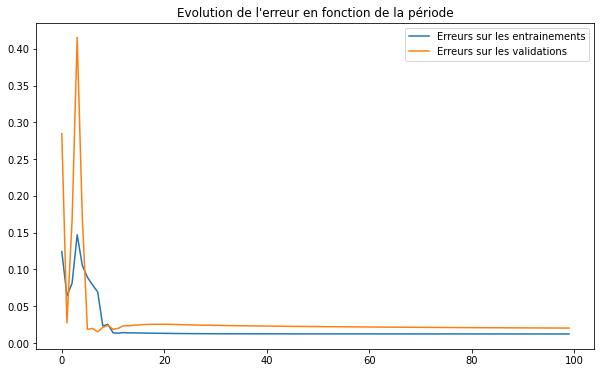

In [21]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [22]:
x_predictions = np.concatenate((x_entrainement_norm[-taille_fenetre-Nbr_Sequences:],x_validation_norm))
dataPredict = prepare_dataset_XY(x_predictions,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)
predictions = model.predict(dataPredict)

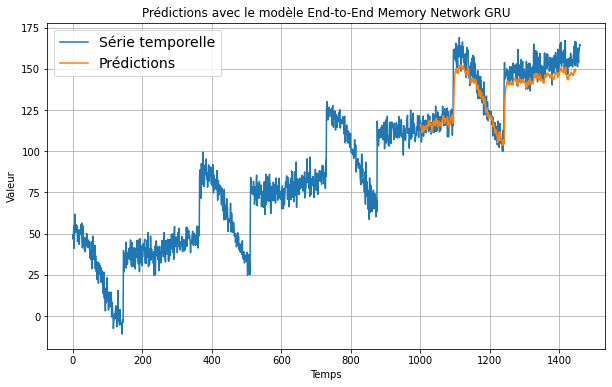

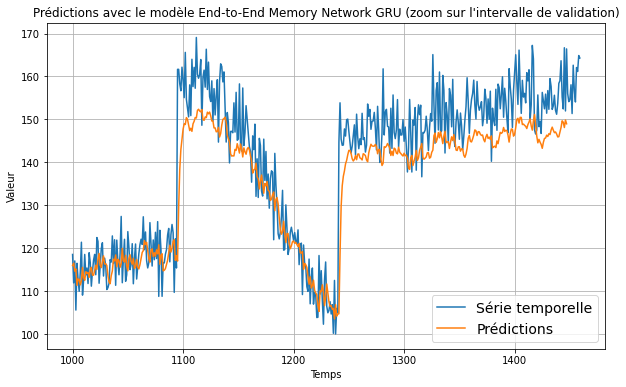

In [24]:
lag = Nbr_Sequences

# Ecart entre la taille des prédictions et la taille de la zone de validation
ecart = len(x_validation)+taille_fenetre+Nbr_Sequences - len(predictions)

# Ce qui n'a pas été pris par la prédiction
reste = ecart - taille_fenetre

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")

if reste != 0:
  affiche_serie(temps[temps_separation:-reste+Nbr_Sequences],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")


plt.title('Prédictions avec le modèle End-to-End Memory Network GRU')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
if reste != 0:
  affiche_serie(temps[temps_separation:-reste+Nbr_Sequences],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
plt.title("Prédictions avec le modèle End-to-End Memory Network GRU (zoom sur l'intervalle de validation)")
plt.show()

In [25]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation:-reste+Nbr_Sequences],np.asarray(predictions[:,0]*std.numpy()+mean.numpy())).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation:-reste+Nbr_Sequences],np.asarray(predictions[:,0]*std.numpy()+mean.numpy())).numpy()

print(mae)
print(mse)

6.560233
72.172844
